In [1]:
# Import libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.neural_network as snn
import sklearn.metrics as sme
import sklearn.cross_decomposition as skd
from radiomics import featureextractor 
import numpy as np
import pandas as pd
from scipy.stats import linregress
from IPython.display import HTML
import util
from multiprocessing import Pool


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/QSM anonymus- 6.22.2023-1528.csv'
motor_df = util.filter_scores(file_dir,'pre-dbs updrs','stim','CORNELL ID')
# Find cases with all required scores
subs,pre_imp,post_imp,pre_updrs_off = util.get_full_cases(motor_df,
                                                          'CORNELL ID',
                                                          'OFF (pre-dbs updrs)',
                                                          'ON (pre-dbs updrs)',
                                                          'OFF meds ON stim 6mo')
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595)
ids = np.asarray(ID_all).astype(int)
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(subs).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
pre_imp = pre_imp[s_cases_idx]
post_imp = post_imp[s_cases_idx]
pre_updrs_off = pre_updrs_off[s_cases_idx]
per_change = post_imp

In [4]:
X_train,X_test,y_train,y_test,train_index,test_index = util.set_split(X_all_c,per_change,1,0.1)
X0_tt,scaler = util.make_feature_matrix(X_train,pre_updrs_off[train_index])
entropy_train = util.calc_entropy(X0_tt.ravel())
entropy_test = util.calc_entropy(X_test.ravel())
print('Split datasets into training ( entropy of',str(entropy_train),') and testing ( entropy of',str(entropy_test),')')


Split datasets into training ( entropy of 16.656225013237975 ) and testing ( entropy of 14.133238756942747 )


In [5]:
est = slm.ElasticNet()
cvn = 5

param_grid = {'alpha': [1e-3,1e-2,1e-1],
          'eps': [1e-4,1e-3,1e-2,1e-3],
          'max_iter':[5000]}

gsc = slm.ElasticNetCV(
    cv=cvn, 
    verbose=True,
    n_jobs=-1)




In [8]:
X_test_in = util.scale_feature_matrix(X_test,pre_updrs_off[test_index],scaler)
estcv = gsc.fit(X0_tt,y_train)
pls = skd.PLSRegression(n_components=1000)
pls.fit(X0_tt, y_train)
n = X_test.shape[0]
results = estcv.predict(X_test_in.reshape([X_test_in.shape[0],
                                           X_test_in.shape[1]*X_test_in.shape[2]]))

print(results)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
.......................................................................................................................................................................

/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/ali/anaconda3/envs/pdradenv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


<function matplotlib.pyplot.show(*args, **kw)>

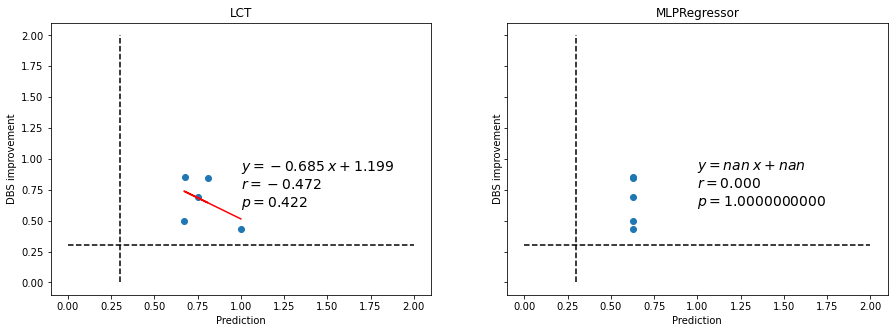

In [7]:

ut_l = results
plt.rcParams["figure.figsize"] = (15,5)
# Cross validation results
[fig,ax] = plt.subplots(1,2,sharex=True, sharey=True)
lr_prepost = linregress(pre_imp[test_index],y_test)
ax[0].scatter(pre_imp[test_index],y_test)
ax[0].plot(pre_imp[test_index],pre_imp[test_index]*lr_prepost.slope+lr_prepost.intercept,'-r')
ax[0].set_title('LCT')
ax[0].set_ylabel("DBS improvement")
ax[0].set_xlabel("Prediction")
# ax[0].set_ylim([0, 1])
# ax[0].set_xlim([0, 1])
text = f"$y={lr_prepost.slope:0.3f}\;x{lr_prepost.intercept:+0.3f}$\n$r = {lr_prepost.rvalue:0.3f}$\n$p = {lr_prepost.pvalue:0.3f}$"
ax[0].text(0.5, 0.5, text,transform=ax[0].transAxes,
     fontsize=14, verticalalignment='top')
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')

lr_pred_qr = linregress(np.asarray(ut_l).ravel(),y_test)
ax[1].scatter(np.asarray(ut_l).ravel(),y_test)
ax[1].plot(np.asarray(ut_l).ravel(),np.asarray(ut_l).ravel()*lr_pred_qr.slope+lr_pred_qr.intercept,'-r')
ax[1].set_title('MLPRegressor')
ax[1].set_ylabel("DBS improvement")
ax[1].set_xlabel("Prediction")
text = f"$y={lr_pred_qr.slope:0.3f}\;x{lr_pred_qr.intercept:+0.3f}$\n$r = {lr_pred_qr.rvalue:0.3f}$\n$p = {lr_pred_qr.pvalue:0.10f}$"
ax[1].text(0.5, 0.5, text,transform=ax[1].transAxes,
     fontsize=14, verticalalignment='top')
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')

plt.style.use('default')
plt.show